In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class VGG16_VSD_Classifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def build_model(self, num_classes=2, fine_tune=False):
        """
        Build VGG16 model for VSD classification
        
        Args:
            num_classes: Number of classes (2 for normal/VSD)
            fine_tune: Whether to fine-tune VGG16 layers
        """
        # Load pre-trained VGG16 without top layers
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        
        # Freeze base model layers initially
        base_model.trainable = fine_tune
        
        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        
        # Output layer
        if num_classes == 2:
            predictions = Dense(1, activation='sigmoid')(x)
            loss = 'binary_crossentropy'
        else:
            predictions = Dense(num_classes, activation='softmax')(x)
            loss = 'categorical_crossentropy'
        
        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)
        
        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=loss,
            metrics=['accuracy']
        )
        
        return self.model
    
    def create_data_generators(self, data_dir, validation_split=0.2):
        """
        Create data generators for training and validation
        
        Args:
            data_dir: Path to dataset directory containing 'normal' and 'vsd' folders
            validation_split: Fraction of data to use for validation
        """
        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            fill_mode='nearest',
            validation_split=validation_split
        )
        
        # Only rescaling for validation
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split
        )
        
        # Training generator
        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',  # Use 'categorical' for multi-class
            subset='training',
            shuffle=True
        )
        
        # Validation generator
        val_generator = val_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',  # Use 'categorical' for multi-class
            subset='validation',
            shuffle=False
        )
        
        return train_generator, val_generator
    
    def train_model(self, train_generator, val_generator, epochs=50, 
                   patience=10, save_path='best_vgg16_vsd_model.h5'):
        """
        Train the VGG16 model
        
        Args:
            train_generator: Training data generator
            val_generator: Validation data generator
            epochs: Number of training epochs
            patience: Early stopping patience
            save_path: Path to save the best model
        """
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                save_path,
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        return self.history
    
    def fine_tune_model(self, train_generator, val_generator, epochs=20):
        """
        Fine-tune the model by unfreezing some VGG16 layers
        """
        # Unfreeze the top layers of VGG16
        base_model = self.model.layers[0]
        base_model.trainable = True
        
        # Fine-tune from this layer onwards
        fine_tune_at = 100
        
        # Freeze all layers before fine_tune_at
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        
        # Use a lower learning rate for fine-tuning
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001/10),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Continue training
        fine_tune_history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            verbose=1
        )
        
        return fine_tune_history
    
    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_generator):
        """Evaluate model performance"""
        # Predictions
        predictions = self.model.predict(test_generator)
        predicted_classes = (predictions > 0.5).astype(int).flatten()
        
        # True labels
        true_classes = test_generator.classes
        
        # Classification report
        class_names = list(test_generator.class_indices.keys())
        print("Classification Report:")
        print(classification_report(true_classes, predicted_classes, 
                                  target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return predictions, predicted_classes
    
    def predict_single_image(self, image_path):
        """Predict on a single image"""
        from tensorflow.keras.preprocessing import image
        
        # Load and preprocess image
        img = image.load_img(image_path, target_size=self.img_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        
        # Make prediction
        prediction = self.model.predict(img_array)
        probability = prediction[0][0]
        
        # Interpret result
        if probability > 0.5:
            result = "VSD Patient"
            confidence = probability
        else:
            result = "Normal Patient"
            confidence = 1 - probability
        
        return result, confidence

# Example usage
def main():
    # Initialize classifier
    classifier = VGG16_VSD_Classifier(img_size=(224, 224), batch_size=32)
    
    # Build model
    model = classifier.build_model(num_classes=2, fine_tune=False)
    print("Model Summary:")
    model.summary()
    
    # Data directory structure should be:
    # dataset/
    #   ├── normal/
    #   │   ├── image1.jpg
    #   │   ├── image2.jpg
    #   │   └── ...
    #   └── vsd/
    #       ├── image1.jpg
    #       ├── image2.jpg
    #       └── ...
    
    data_dir = "/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/preproDataset"  # Update this path
    
    # Create data generators
    train_gen, val_gen = classifier.create_data_generators(data_dir)
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Class indices: {train_gen.class_indices}")
    
    # Train model
    history = classifier.train_model(
        train_gen, 
        val_gen, 
        epochs=5, 
        patience=10
    )
    
    # Plot training history
    classifier.plot_training_history()
    
    # Optional: Fine-tune the model
    # fine_tune_history = classifier.fine_tune_model(train_gen, val_gen, epochs=20)
    
    # Evaluate model
    classifier.evaluate_model(val_gen)
    
    # Example single prediction
    # result, confidence = classifier.predict_single_image("path/to/test/image.jpg")
    # print(f"Prediction: {result} (Confidence: {confidence:.2f})")


Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 2019 images belonging to 2 classes.
Found 504 images belonging to 2 classes.
Training samples: 2019
Validation samples: 504
Class indices: {'normal': 0, 'vsd': 1}
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8134 - loss: 0.4679
Epoch 1: val_accuracy improved from -inf to 0.86706, saving model to best_vgg16_vsd_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8140 - loss: 0.4673 - val_accuracy: 0.8671 - val_loss: 0.3764 - learning_rate: 1.0000e-04
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8751 - loss: 0.3831
Epoch 2: val_accuracy did not improve from 0.86706
64/64 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8750 - loss: 0.3832 - val_accuracy: 0.8671 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8592 - loss: 0.3977
Epoch 3: val_accuracy did not improve from 0.86706
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8593 - loss: 0.3976 - val_accuracy: 0.8671 - val_loss: 0.3564 - learning_rate: 1.0000e-04
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8583 - loss: 0.3819
Epoch 4: val_accuracy did not improve from 0.86706
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8584 - loss: 0.3817 - val_accuracy: 0.8671 - val_loss: 0.3466 - learning_rate: 1.0000e-04
Epoch 5/5
64/64 ━━━━━━━━━

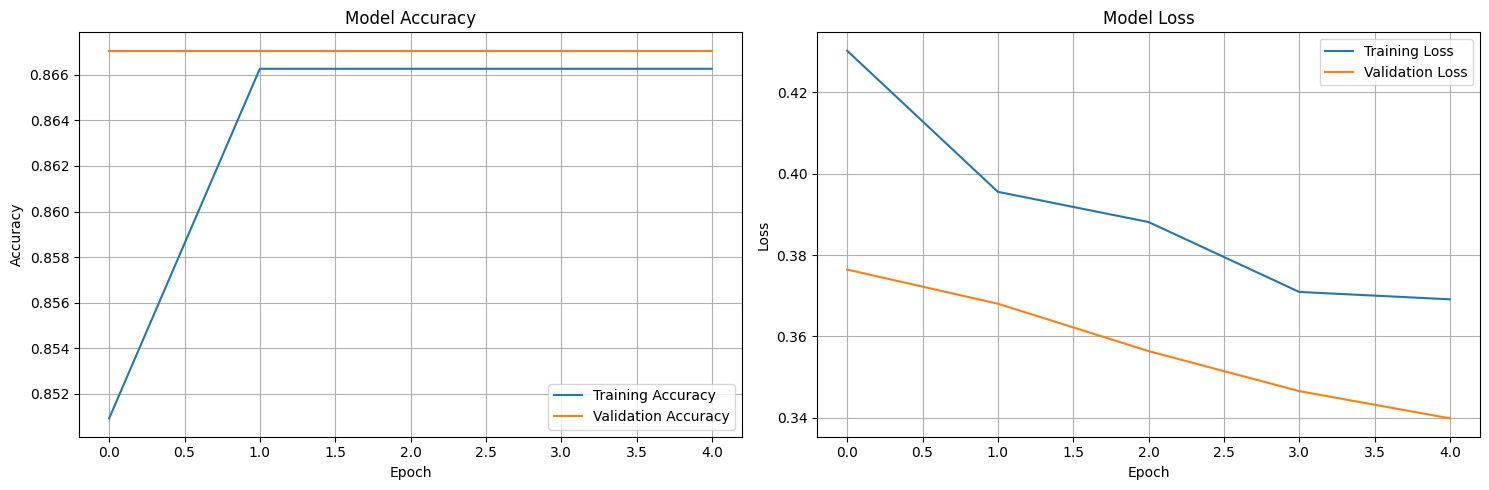

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        67
         vsd       0.87      1.00      0.93       437

    accuracy                           0.87       504
   macro avg       0.43      0.50      0.46       504
weighted avg       0.75      0.87      0.81       504



/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

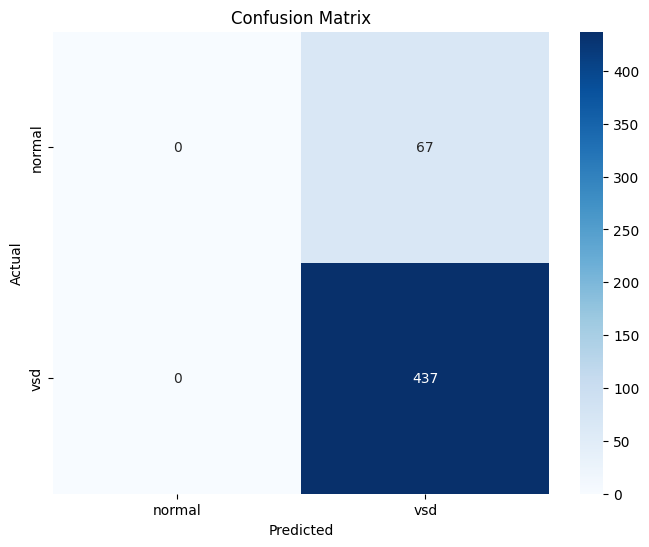

In [7]:
if __name__ == "__main__":
    main()